# Digging Beneath the Surface

*Benjamin Johnson*


*June 11, 2022*

[Home](https://fastdatascientist.github.io/Digging-Beneath-the-Surface/)

[About Me](https://fastdatascientist.github.io/Digging-Beneath-the-Surface/author.html)

[Previous Posts](https://fastdatascientist.github.io/Digging-Beneath-the-Surface/posts.html)

## Investment Simulator

After two baseball articles (and over a 4 year hiatus!), we're finally tackling another subject. The world has been buzzing with uncertainty with issues such as rising gas prices (US average > $5/gal), a 40-year inflation high of 8.9% YoY, and the largest stock market drop since 2008. However, we're setting our sights on something more positive today. Even with an 18.16% reduction in the Standard and Poor's (S&P) 500 index this year, it has more than doubled since I started my career and began investing. A buy and hold strategy has lead to consistent returns over longer periods. Our goal for this article is to estimate investment growth over time by feeding historical rates of return into a Monte Carlo simulation. 

In [272]:
import pandas as pd
import numpy as np
import math
import random

df = pd.read_csv(sp-500-historical-annual-returns.csv", encoding="utf-8")
df.head(6)

,year,ror
0,1928,37.88
1,1929,-11.91
2,1930,-28.48
3,1931,-47.07
4,1932,-15.15
5,1933,46.59


The imported file contains the yearly rate of return for the S&P 500 index from 1928 thru 2021.
&nbsp;

**Notes**: 
- S&P 500 index was created in 1957 as a benchmark for the overall stock market. Prior to this date, the returns are for the S&P 90 Stock Index, formed in 1928.
- 2022 has been included since it's a partial year. The current rate of return as of June 11 is -18.16%.
- Credit to [macrotrends](https://www.macrotrends.net/2488/sp500-10-year-daily-chart/) for providing the data.

Let's limit our dataset to only include the last 50 years of returns.

In [111]:
from datetime import date

current_year = date.today().year

df50 = df[df['year'] >= current_year - 50]
df50.sort_values('year').head()

,year,ror
44,1972,15.63
45,1973,-17.37
46,1974,-29.72
47,1975,31.55
48,1976,19.15


In addition to the rates of return, our investment growth will also be dependendent on our contributions and our investment horizon. For simplicity, let's start by assuming constant contributions of $X per year for Y years.

In [33]:
X = 6000 # The 2022 IRA contribution is $6K per individual. A Roth IRA allows us to contribute after tax dollars with TAX-FREE GROWTH!
Y = 30   # This factor will greatly depend on an individual's age and years to retirement

Investment = X * Y
print("With 0% rate of return, our investment of $" + str(X) + "/yr for " + str(Y) + " years will yield a total of $" + str(Investment))

With 0% rate of return, our investment of $6000/yr for 30 years will yield a total of $180000


Now, let's randomly select rates of return (with replacement) from the last 50 years to create a new estimate that accounts for growth.

In [135]:
# Create uniform random number between min and max value
def get_rand_number(min_value, max_value):
    range = max_value - min_value
    choice = random.uniform(0,1)
    return int(min_value + round(range*choice, 0))

ror = []
for i in np.arange(0, Y):
    temp = df50.iloc[get_rand_number(0, 49)]['ror']
    ror.append(temp)
    print("The rate of return for Year " + str(i+1) + " = " + str(temp) + "%")

The rate of return for Year 1 = 28.88%
The rate of return for Year 2 = -29.72%
The rate of return for Year 3 = 19.53%
The rate of return for Year 4 = 8.99%
The rate of return for Year 5 = 19.15%
The rate of return for Year 6 = 12.31%
The rate of return for Year 7 = 23.45%
The rate of return for Year 8 = 23.45%
The rate of return for Year 9 = 13.62%
The rate of return for Year 10 = 31.55%
The rate of return for Year 11 = 13.41%
The rate of return for Year 12 = 3.53%
The rate of return for Year 13 = 3.53%
The rate of return for Year 14 = 8.99%
The rate of return for Year 15 = -6.56%
The rate of return for Year 16 = 0.0%
The rate of return for Year 17 = 26.67%
The rate of return for Year 18 = 2.03%
The rate of return for Year 19 = 13.41%
The rate of return for Year 20 = -0.73%
The rate of return for Year 21 = -6.24%
The rate of return for Year 22 = 14.76%
The rate of return for Year 23 = 26.33%
The rate of return for Year 24 = -38.49%
The rate of return for Year 25 = 20.26%
The rate of re

The next step is to calculate our investment total for these rates of return.

In [161]:
def InvestmentSimulator(Contribution, Rates):
    Balance = 0
    for i in Rates:
        Balance = round(Balance * (1 + i/100) + Contribution, 2)
    return Balance
    
InvestmentTotal = InvestmentSimulator(X, ror)
print("Our investments after " + str(Y) + " years have grown to $" + str("{:,.2f}".format(InvestmentTotal)) + ", consisting of $" + str("{:,.2f}".format(X * Y)) + " in contributions and $" + 
      str("{:,.2f}".format(InvestmentTotal - X * Y)) + " in growth!")

Our investments after 30 years have grown to $318,513.80, consisting of $180,000.00 in contributions and $138,513.80 in growth!


While we have one estimate of our potential investments, itwould be more meaningful to run numerous simulations to get a better idea of the variability. We'll modify our previous code to easily run S number of scenarios.

In [240]:
def RunScenarios(Scenarios, Contribution, Years):
    FinalBalances = []
    for i in np.arange(0, Scenarios):
        ror = [] 
        for j in np.arange(0, Years):
            temp = df50.iloc[get_rand_number(0, 49)]['ror']
            ror.append(temp)
        InvestmentTotal = InvestmentSimulator(Contribution, ror)
        FinalBalances.append(InvestmentTotal)
    return(pd.Series(FinalBalances))
            
# Run 10,000 scenarios where we invest $6,000 per year for 30 years    
FinalBalances = RunScenarios(10000, 6000, 30)    
FinalBalances.head()

0     467519.11
1     763951.86
2    1533146.57
3     133668.99
4    1224208.63
dtype: float64

Now that we have results across many scenarios, let's look at some summary statistics. 

In [273]:
print("The minimum investment account balance was:          $" + str("{:,.2f}".format(FinalBalances.min())))
print("The 5th percentile investment account balance was:   $" + str("{:,.2f}".format(FinalBalances.quantile(0.05))))
print("The 25th percentile investment account balance was:  $" + str("{:,.2f}".format(FinalBalances.quantile(0.25))))
print("The median investment account balance was:           $" + str("{:,.2f}".format(FinalBalances.median())))
print("The 75th percentile investment account balance was:  $" + str("{:,.2f}".format(FinalBalances.quantile(0.75))))
print("The 95th percentile investment account balance was:  $" + str("{:,.2f}".format(FinalBalances.quantile(0.95))))
print("The maximum investment account balance was:          $" + str("{:,.2f}".format(FinalBalances.max())))
print("The standard deviation was:                          $" + str("{:,.2f}".format(FinalBalances.std())))
print("The 1.5 IQR was:                                     $" + str("{:,.2f}".format((FinalBalances.quantile(0.75) - FinalBalances.quantile(0.25)) * 1.5)))
print("")
print("Reminder: Our contributions over " + str(Y) + " years was:       $" + str("{:,.2f}".format(X * Y)))
print(str(100 - FinalBalances[FinalBalances < X * Y].count() / FinalBalances.count() * 100) + "% of scenarios yielded a final balance greater than the contributions")

The minimum investment account balance was:          $73,481.21
The 5th percentile investment account balance was:   $232,602.54
The 25th percentile investment account balance was:  $442,418.84
The median investment account balance was:           $688,562.56
The 75th percentile investment account balance was:  $1,076,611.44
The 95th percentile investment account balance was:  $1,950,454.86
The maximum investment account balance was:          $5,535,653.08
The standard deviation was:                          $566,774.03
The 1.5 IQR was:                                     $951,288.89

Reminder: Our contributions over 30 years was:       $180,000.00
98.07% of scenarios yielded a final balance greater than the contributions


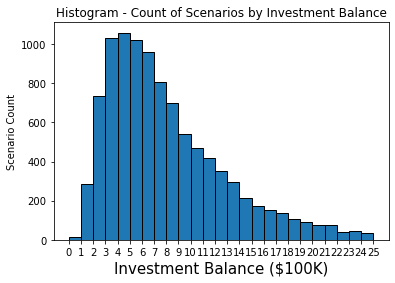

In [320]:
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import pandas as pd

FinalBalancesThousandhousand = FinalBalances / 100000

bins = []

for i in range(0, 26):
    bins.append(i)
        
plt.hist(FinalBalancesOneHundredthousand, bins=bins, edgecolor="k")
plt.xticks(bins)
plt.xlabel('Investment Balance ($100K)', fontsize=15)
plt.ylabel("Scenario Count")
plt.title("Histogram - Count of Scenarios by Investment Balance")
plt.show()

Our median estimate yielded over +\\$500K (+282%) growth across our investing horizon! Even when looking at worst case scenarios, we still experienced growth in over 98% of the simulated scenarios. On the flip side, over 25% of scenarios yielded a final balance over \\$1M (+\\$820K growth). Pretty darn good for only \\$180K in contributions!
&nbsp;

Although not mentioned to this point, there are some major assumptions made throughout this analyis. The biggest two being assumptions that yearly rates of return are independent from one another and that future rates will mirror historical returns. Investors have quarreled over these assumptions for years, and it doesn't seem like the discussion is going away anytime soon. That being said, the numbers in this analysis seem to indicate positive results even if you dialed back your expectations from the estimated median to a lower percentile. It's always a great time to invest for your future!
&nbsp;

That's all for today - keep your eyes peeled for some brand new topics beginning in July!
&nbsp;

Until next time,
&nbsp;

Ben